# Курсовой проект для курса "Python для Data Science"

#### Задание:
Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры). С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).

#### Целевая переменная: 
Price

#### Метрика качества:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

#### Требования к решению:

1) R2 > 0.6

2) Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}_solution.ipynb, пример SShirkin_solution.ipynb

3) Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}_predictions.csv, пример SShirkin_predictions.csv Файл должен содержать два поля: Id, Price и в файле должна быть 5001 строка (шапка + 5000 предсказаний).

# РЕШЕНИЕ

## 0. Подключение библиотек и скриптов

In [16]:
import numpy as np
import pandas as pd
import random

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2

from sklearn.metrics import mean_squared_error as mse, r2_score as r2

import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

matplotlib.rcParams.update({'font.size': 14})

## 1. Используемые функции

In [17]:
# 1. Уменьшение объема памяти, занимаемого датасетом
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [18]:
# 2. Оценка качества модели и график preds vs true
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
   
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

## 2. Пути к директориям и файлам

In [19]:
DATASET_PATH_TRAIN = './train.csv'
DATASET_PATH_TEST = './test.csv'

## 3. Загрузка данных

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [20]:
# Загружаем данные train
df_train = pd.read_csv(DATASET_PATH_TRAIN, sep=',')
# Сжимаем объем датасета train
df_train = reduce_mem_usage(df_train)
df_train.head()

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.937500
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.437500
2,4765,53,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.906250
3,5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.234375
4,10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531250


In [21]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   DistrictId     10000 non-null  int16   
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

In [22]:
# Загружаем данные test
df_test = pd.read_csv(DATASET_PATH_TEST, sep=',')
# Сжимаем объем датасета train
df_test = reduce_mem_usage(df_test)
df_test.head()

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.21 MB
Decreased by 70.3%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882645,33.432781,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263184,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597818,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046608,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [23]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             5000 non-null   int16   
 1   DistrictId     5000 non-null   int16   
 2   Rooms          5000 non-null   float32 
 3   Square         5000 non-null   float32 
 4   LifeSquare     3959 non-null   float32 
 5   KitchenSquare  5000 non-null   float32 
 6   Floor          5000 non-null   int8    
 7   HouseFloor     5000 non-null   float32 
 8   HouseYear      5000 non-null   int16   
 9   Ecology_1      5000 non-null   float32 
 10  Ecology_2      5000 non-null   category
 11  Ecology_3      5000 non-null   category
 12  Social_1       5000 non-null   int8    
 13  Social_2       5000 non-null   int16   
 14  Social_3       5000 non-null   int16   
 15  Healthcare_1   2623 non-null   float32 
 16  Helthcare_2    5000 non-null   int8    
 17  Shops_1        5000 non-null   in

## 4. Приведение типов

### 4.1. Приведение типов для train

In [24]:
# Смотрим типы данных
df_train.dtypes

Id                  int16
DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

In [25]:
df_train['Id'] = df_train['Id'].astype('category')
df_train['DistrictId'] = df_train['DistrictId'].astype('category')

In [26]:
df_train.dtypes.value_counts()

float32     8
int8        4
category    3
int16       2
int32       1
category    1
category    1
dtype: int64

In [27]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  category
 1   DistrictId     10000 non-null  category
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

### 4.2. Приведение типов для test

In [28]:
df_test.dtypes

Id                  int16
DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int16
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
dtype: object

In [29]:
df_test['Id'] = df_test['Id'].astype('category')
df_test['DistrictId'] = df_test['DistrictId'].astype('category')

In [30]:
df_test.dtypes.value_counts()

float32     7
int8        4
int16       3
category    3
category    1
category    1
dtype: int64

In [31]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             5000 non-null   category
 1   DistrictId     5000 non-null   category
 2   Rooms          5000 non-null   float32 
 3   Square         5000 non-null   float32 
 4   LifeSquare     3959 non-null   float32 
 5   KitchenSquare  5000 non-null   float32 
 6   Floor          5000 non-null   int8    
 7   HouseFloor     5000 non-null   float32 
 8   HouseYear      5000 non-null   int16   
 9   Ecology_1      5000 non-null   float32 
 10  Ecology_2      5000 non-null   category
 11  Ecology_3      5000 non-null   category
 12  Social_1       5000 non-null   int8    
 13  Social_2       5000 non-null   int16   
 14  Social_3       5000 non-null   int16   
 15  Healthcare_1   2623 non-null   float32 
 16  Helthcare_2    5000 non-null   int8    
 17  Shops_1        5000 non-null   in

## 5. Распределение целевой переменной

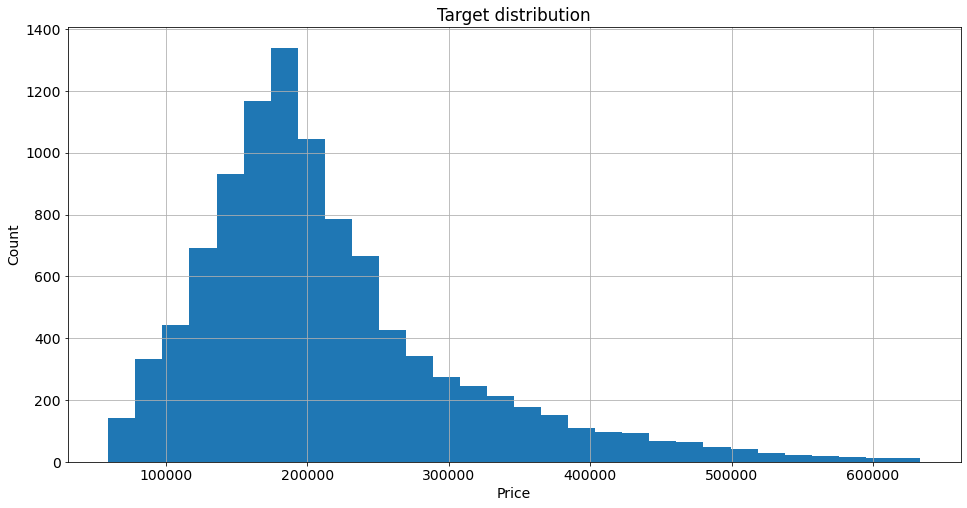

In [32]:
plt.figure(figsize = (16, 8))

df_train['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

In [33]:
# Определяем среднее и медиану целевой переменной
target_mean = round(df_train['Price'].mean(), 2)
target_median = df_train['Price'].median()
target_mode = df_train['Price'].mode()[0]
print(f' Средннее: {target_mean}, Медиана: {target_median}')

 Средннее: 214139.22, Медиана: 192269.65625


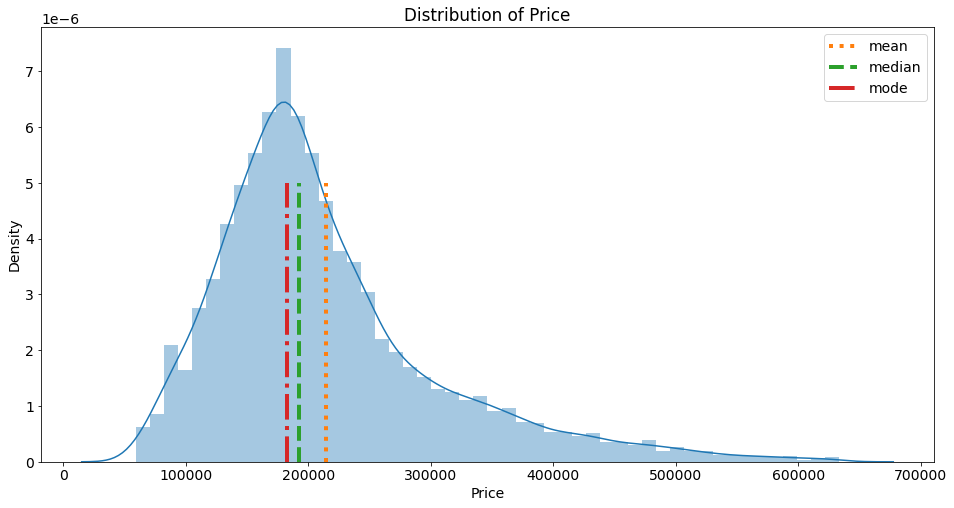

In [34]:
plt.figure(figsize = (16, 8))

sns.distplot(df_train['Price'], bins=50)

y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 10, y, label='median', linestyle='--', linewidth=4)
plt.plot([target_mode] * 10, y, label='mode', linestyle='-.', linewidth=4)

plt.title('Distribution of Price')
plt.legend()
plt.show()

mu = 214138.86 and sigma = 92867.65


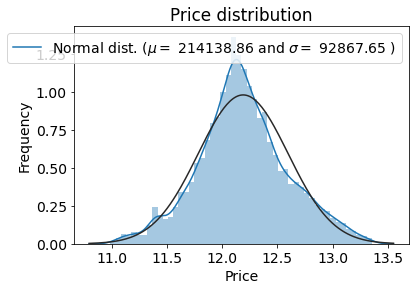

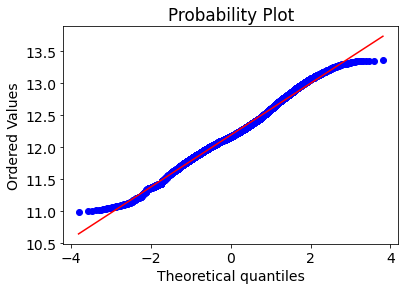

In [35]:
# Исследуем нормальное распределение целевой переменной
price_log = np.log1p(df_train['Price'])
sns.distplot(price_log, fit=norm)

mu, sigma = norm.fit(df_train['Price'])

print(f'mu = {mu:.2f} and sigma = {sigma:.2f}')

plt.legend(
    [f'Normal dist. ($\mu=$ {mu:.2f} and $\sigma=$ {sigma:.2f} )'], loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')

# QQ-plot
fig = plt.figure()
res = stats.probplot(price_log, plot=plt)
plt.show()

## 6. Анализ данных

In [36]:
df_train.columns.to_list()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price']

### 6.1. Собираем количественные и категориальные признаки

##### Для train

In [37]:
# Собираем количественные признаки
df_train_num_features = df_train[['Rooms','Square','LifeSquare','KitchenSquare', 'Floor',
 'HouseFloor','HouseYear','Ecology_1','Social_1','Social_2','Social_3','Healthcare_1',
 'Helthcare_2','Shops_1']]
df_train_num_features.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
0,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,33,7976,5,NaN,0,11
1,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,46,10309,1,240.0,1,16
2,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,34,7759,0,229.0,1,3
3,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,23,5735,3,1084.0,0,5
4,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,35,5776,1,2078.0,2,4


In [38]:
df_train_num_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Rooms          10000 non-null  float32
 1   Square         10000 non-null  float32
 2   LifeSquare     7887 non-null   float32
 3   KitchenSquare  10000 non-null  float32
 4   Floor          10000 non-null  int8   
 5   HouseFloor     10000 non-null  float32
 6   HouseYear      10000 non-null  int32  
 7   Ecology_1      10000 non-null  float32
 8   Social_1       10000 non-null  int8   
 9   Social_2       10000 non-null  int16  
 10  Social_3       10000 non-null  int16  
 11  Healthcare_1   5202 non-null   float32
 12  Helthcare_2    10000 non-null  int8   
 13  Shops_1        10000 non-null  int8   
dtypes: float32(7), int16(2), int32(1), int8(4)
memory usage: 390.8 KB


In [39]:
# Смотрим статистики количественных признаков
df_train_num_features.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000
mean,1.890500,56.315712,37.199596,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300
std,0.839523,21.058718,86.241112,28.561113,5.241148,6.776192,2.005003e+05,0.119026,17.532614,4006.799803,23.831875,1021.518982,1.493601,4.806341
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000
50%,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000
75%,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000
max,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000


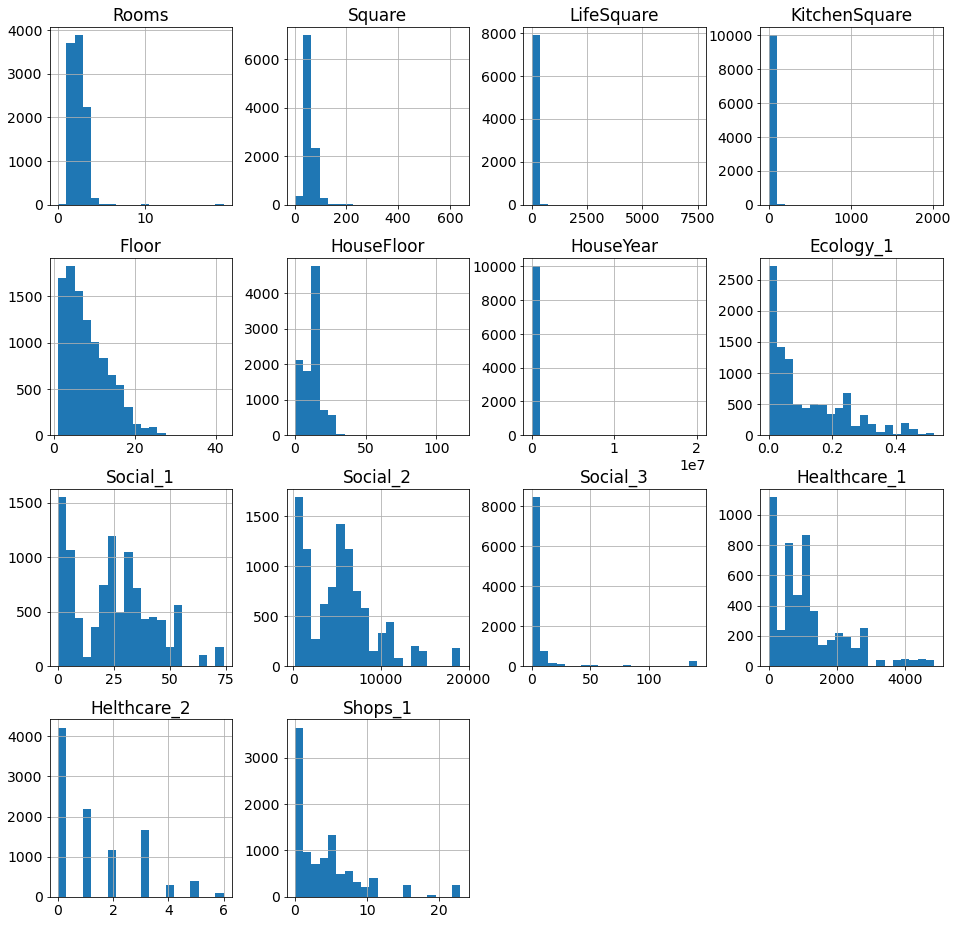

In [40]:
# Строим гистограммы для признаков
df_train_num_features.hist(figsize=(16,16), bins=20, grid=True);

In [41]:
# Собираем категориальные признаки
df_train_cat_features = df_train[['Ecology_2','Ecology_3','Shops_2']]
df_train_cat_features.head()

,Ecology_2,Ecology_3,Shops_2
0,B,B,B
1,B,B,B
2,B,B,B
3,B,B,B
4,B,B,B


In [42]:
df_train_cat_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Ecology_2  10000 non-null  category
 1   Ecology_3  10000 non-null  category
 2   Shops_2    10000 non-null  category
dtypes: category(3)
memory usage: 29.7 KB


In [43]:
# Смотрим значения признаков
for cat_feature in df_train_cat_features.columns.tolist():
    print(str(cat_feature) + '\n\n' + str(df_train_cat_features[cat_feature].value_counts()) + '\n' + '*' * 80 + '\n')

Ecology_2

B    9903
A      97
Name: Ecology_2, dtype: int64
********************************************************************************

Ecology_3

B    9725
A     275
Name: Ecology_3, dtype: int64
********************************************************************************

Shops_2

B    9175
A     825
Name: Shops_2, dtype: int64
********************************************************************************



##### Для test

In [44]:
# Собираем количественные признаки
df_test_num_features = df_test[['Rooms','Square','LifeSquare','KitchenSquare', 'Floor',
 'HouseFloor','HouseYear','Ecology_1','Social_1','Social_2','Social_3','Healthcare_1',
 'Helthcare_2','Shops_1']]
df_test_num_features.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
0,2.0,49.882645,33.432781,6.0,6,14.0,1972,0.310199,11,2748,1,NaN,0,0
1,2.0,69.263184,NaN,1.0,6,1.0,1977,0.075779,6,1437,3,NaN,0,2
2,1.0,13.597818,15.948246,12.0,2,5.0,1909,0.000000,30,7538,87,4702.0,5,5
3,2.0,73.046608,51.940842,9.0,22,22.0,2007,0.101872,23,4583,3,NaN,3,3
4,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,2,629,1,NaN,0,0


In [45]:
df_test_num_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Rooms          5000 non-null   float32
 1   Square         5000 non-null   float32
 2   LifeSquare     3959 non-null   float32
 3   KitchenSquare  5000 non-null   float32
 4   Floor          5000 non-null   int8   
 5   HouseFloor     5000 non-null   float32
 6   HouseYear      5000 non-null   int16  
 7   Ecology_1      5000 non-null   float32
 8   Social_1       5000 non-null   int8   
 9   Social_2       5000 non-null   int16  
 10  Social_3       5000 non-null   int16  
 11  Healthcare_1   2623 non-null   float32
 12  Helthcare_2    5000 non-null   int8   
 13  Shops_1        5000 non-null   int8   
dtypes: float32(7), int16(3), int8(4)
memory usage: 185.7 KB


In [46]:
# Смотрим статистики количественных признаков
df_test_num_features.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,1.910000,56.449501,36.158760,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657227,1.31940,4.242800
std,0.838587,19.092793,17.825277,9.950147,5.483228,6.789167,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744995,1.47994,4.777365
min,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,1.000000,41.906230,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,2.000000,52.921339,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,2.000000,66.285130,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,17.000000,223.453690,303.071106,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


In [47]:
# Собираем категориальные признаки
df_test_cat_features = df_test[['Ecology_2','Ecology_3','Shops_2']]
df_test_cat_features.head()

,Ecology_2,Ecology_3,Shops_2
0,B,B,B
1,B,B,B
2,B,B,B
3,B,B,B
4,B,B,A


In [48]:
df_test_cat_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Ecology_2  5000 non-null   category
 1   Ecology_3  5000 non-null   category
 2   Shops_2    5000 non-null   category
dtypes: category(3)
memory usage: 15.1 KB


In [49]:
# Смотрим значения признаков
for cat_feature in df_test_cat_features.columns.tolist():
    print(str(cat_feature) + '\n\n' + str(df_test_cat_features[cat_feature].value_counts()) + '\n' + '*' * 80 + '\n')

Ecology_2

B    4952
A      48
Name: Ecology_2, dtype: int64
********************************************************************************

Ecology_3

B    4851
A     149
Name: Ecology_3, dtype: int64
********************************************************************************

Shops_2

B    4588
A     412
Name: Shops_2, dtype: int64
********************************************************************************



### 6.2. Обработка выбросов

##### 6.2.1. Анализ признака 'Rooms'

###### для train

In [50]:
# Анализируя гистограмму и количество различных величин, замечаем, большую разницу между максимальным количеством комнат 19 и медианой 2. Заметим, что комнат может быть 0, если квартира свободной планировк
df_train_num_features['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [51]:
# Площадь таких комнат менее 4 квадратных метров. Вероянее всего, данные ошибочны
df_train_num_features.loc[df_train_num_features['Rooms'] > 8, ['Rooms', 'LifeSquare']]

,Rooms,LifeSquare
377,10.0,36.223072
1454,19.0,21.779287
8849,10.0,38.420681


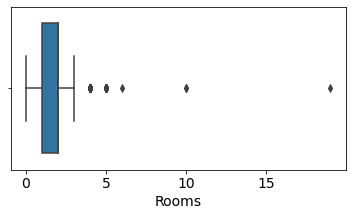

In [52]:
# Определяем выбросы в данных признака
plt.figure(figsize=(6, 3))
sns.boxplot(df_train_num_features['Rooms'], whis=1.5)
plt.xlabel('Rooms')
plt.show()

In [53]:
# Заменяем выбросы медианой
df_train_num_features.loc[df_train_num_features['Rooms'] > 8, 'Rooms'] = df_train_num_features['Rooms'].median()

In [54]:
df_train_num_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Rooms          10000 non-null  float32
 1   Square         10000 non-null  float32
 2   LifeSquare     7887 non-null   float32
 3   KitchenSquare  10000 non-null  float32
 4   Floor          10000 non-null  int8   
 5   HouseFloor     10000 non-null  float32
 6   HouseYear      10000 non-null  int32  
 7   Ecology_1      10000 non-null  float32
 8   Social_1       10000 non-null  int8   
 9   Social_2       10000 non-null  int16  
 10  Social_3       10000 non-null  int16  
 11  Healthcare_1   5202 non-null   float32
 12  Helthcare_2    10000 non-null  int8   
 13  Shops_1        10000 non-null  int8   
dtypes: float32(7), int16(2), int32(1), int8(4)
memory usage: 390.8 KB


###### для test

In [55]:
# Замечаем, большую разницу между максимальным количеством комнат 19 и медианой 2. Заметим, что комнат может быть 0, если квартира свободной планировк
df_test_num_features['Rooms'].value_counts()

2.0     2030
1.0     1769
3.0     1099
4.0       90
5.0        7
0.0        2
6.0        2
17.0       1
Name: Rooms, dtype: int64

In [56]:
# Заменяем выбросы в 'Rooms' медианой
df_test_num_features.loc[df_test_num_features['Rooms'] > 6, 'Rooms'] = df_test_num_features['Rooms'].median()

##### 6.2.2. Анализ признаков 'KitchenSquare', 'LifeSquare', 'Square'

###### для train

In [57]:
df_train_num_features[['Square', 'LifeSquare','KitchenSquare']].describe()

,Square,LifeSquare,KitchenSquare
count,10000.000000,7887.000000,10000.000000
mean,56.315712,37.199596,6.273300
std,21.058718,86.241112,28.561113
min,1.136859,0.370619,0.000000
25%,41.774879,22.769833,1.000000
50%,52.513309,32.781261,6.000000
75%,65.900627,45.128803,9.000000
max,641.065186,7480.592285,2014.000000


In [58]:
df_train_num_features[['Square', 'LifeSquare', 'KitchenSquare']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Square         10000 non-null  float32
 1   LifeSquare     7887 non-null   float32
 2   KitchenSquare  10000 non-null  float32
dtypes: float32(3)
memory usage: 117.3 KB


In [59]:
df_train_num_features["LifeSquare"].isnull().sum()

2113

In [60]:
# Находим записи с жилой площадью < 10 и заменяем их на 10
df_train_num_features.loc[df_train_num_features['LifeSquare'] < 10,'LifeSquare'] = 10

In [61]:
# Находим записи кухней < 3 и заменяем их на 3
df_train_num_features.loc[df_train_num_features['KitchenSquare'] < 3,'KitchenSquare'] = 3

In [62]:
# Находим записи, в которых общая площадь меньше жилой + кухня
df_train_num_features[df_train_num_features['Square'] < df_train_num_features['LifeSquare'] + df_train_num_features['KitchenSquare']].head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
3,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,23,5735,3,1084.0,0,5
14,1.0,53.769096,52.408028,3.0,5,4.0,1977,0.072158,2,629,1,NaN,0,0
28,1.0,42.530045,43.967758,3.0,3,9.0,2014,0.034656,0,168,0,NaN,0,0
42,2.0,56.494316,54.723568,3.0,9,17.0,1977,0.007122,1,264,0,NaN,0,1
44,3.0,104.211395,106.340401,3.0,20,0.0,2017,0.060753,15,2787,2,520.0,0,7


In [63]:
# Заменяем в таких записях общую площадь на площадь кухни + жилая площадь
df_train_num_features.loc[df_train_num_features['Square'] < df_train_num_features['LifeSquare'] + df_train_num_features['KitchenSquare'], 'Square'] = df_train_num_features.loc[df_train_num_features['Square'] < df_train_num_features['LifeSquare'] + df_train_num_features['KitchenSquare'], 'LifeSquare'] + df_train_num_features.loc[df_train_num_features['Square'] < df_train_num_features['LifeSquare'] + df_train_num_features['KitchenSquare'], 'KitchenSquare']

###### для test

In [64]:
df_test_num_features[['Square', 'LifeSquare','KitchenSquare']].describe()

,Square,LifeSquare,KitchenSquare
count,5000.000000,3959.000000,5000.000000
mean,56.449501,36.158760,5.976800
std,19.092793,17.825277,9.950147
min,1.378543,0.333490,0.000000
25%,41.906230,23.092026,1.000000
50%,52.921339,32.925087,6.000000
75%,66.285130,45.174091,9.000000
max,223.453690,303.071106,620.000000


In [65]:
df_test_num_features[['Square', 'LifeSquare', 'KitchenSquare']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Square         5000 non-null   float32
 1   LifeSquare     3959 non-null   float32
 2   KitchenSquare  5000 non-null   float32
dtypes: float32(3)
memory usage: 58.7 KB


In [66]:
df_test_num_features["LifeSquare"].isnull().sum()

1041

In [67]:
# Находим записи с жилой площадью < 10 и заменяем их на 10
df_test_num_features.loc[df_test_num_features['LifeSquare'] < 10,'LifeSquare'] = 10

In [68]:
# Находим записи кухней < 3 и заменяем их на 3
df_test_num_features.loc[df_test_num_features['KitchenSquare'] < 3,'KitchenSquare'] = 3

In [69]:
# Находим записи, в которых общая площадь меньше жилой + кухня
df_test_num_features[df_test_num_features['Square'] < df_test_num_features['LifeSquare'] + df_test_num_features['KitchenSquare']].head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
2,1.0,13.597818,15.948246,12.0,2,5.0,1909,0.000000,30,7538,87,4702.0,5,5
27,1.0,48.610661,48.752502,3.0,4,3.0,1977,0.437885,23,5735,3,1084.0,0,5
29,2.0,65.550690,61.689281,10.0,13,22.0,1988,0.037178,52,11217,1,2300.0,1,7
39,1.0,42.413792,42.434887,10.0,12,17.0,2017,0.011654,4,915,0,NaN,0,0
43,1.0,37.484058,40.593037,3.0,4,17.0,1977,0.007122,1,264,0,NaN,0,1


In [70]:
# Заменяем в таких записях общую площадь на площадь кухни + жилая площадь
df_test_num_features.loc[df_test_num_features['Square'] < df_test_num_features['LifeSquare'] + df_test_num_features['KitchenSquare'], 'Square'] = df_test_num_features.loc[df_test_num_features['Square'] < df_test_num_features['LifeSquare'] + df_test_num_features['KitchenSquare'], 'LifeSquare'] + df_test_num_features.loc[df_test_num_features['Square'] < df_test_num_features['LifeSquare'] + df_test_num_features['KitchenSquare'], 'KitchenSquare']

##### 6.2.3. Анализ признаков 'Floor', 'HouseFloor'

###### для train

In [71]:
# Определяем ошибку, когда в доме 0 этажей
df_train_num_features[df_train_num_features['HouseFloor'] == 0].head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
7,2.0,80.312927,NaN,3.0,14,0.0,1977,0.075779,6,1437,3,NaN,0,2
23,3.0,118.907608,NaN,3.0,2,0.0,1977,0.006076,30,5285,0,645.0,6,6
26,3.0,106.958870,10.000000,3.0,17,0.0,2018,0.072158,2,629,1,NaN,0,0
39,2.0,60.503250,NaN,3.0,16,0.0,1977,0.034656,0,168,0,NaN,0,0
44,3.0,109.340401,106.340401,3.0,20,0.0,2017,0.060753,15,2787,2,520.0,0,7


In [72]:
# Заменяем такие значения на медиану
df_train_num_features.loc[df_train_num_features['HouseFloor'] == 0, 'HouseFloor'] = df_train_num_features['HouseFloor'].median()

In [73]:
# Определяем ошибку в данных, когда этаж больше количества этажей в доме
df_train_num_features[df_train_num_features['Floor'] > df_train_num_features['HouseFloor']].head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
7,2.0,80.312927,NaN,3.0,14,13.0,1977,0.075779,6,1437,3,NaN,0,2
14,1.0,55.408028,52.408028,3.0,5,4.0,1977,0.072158,2,629,1,NaN,0,0
16,2.0,49.360649,31.993963,5.0,6,5.0,1983,0.051815,5,1227,0,NaN,0,0
21,2.0,64.711838,NaN,3.0,15,1.0,1977,0.211401,9,1892,0,NaN,0,1
26,3.0,106.958870,10.000000,3.0,17,13.0,2018,0.072158,2,629,1,NaN,0,0


In [74]:
# заменяем такие записи
floor_delta_housefloor = df_train_num_features['HouseFloor'] - df_train_num_features['Floor']
floor_delta_housefloor = np.abs(floor_delta_housefloor[floor_delta_housefloor<0])

floor_outliers = df_train_num_features[df_train_num_features['Floor'] > df_train_num_features['HouseFloor']].index

df_train_num_features.loc[floor_outliers, 'Floor'] = df_train_num_features.loc[floor_outliers, 'HouseFloor'].apply(
    lambda x: random.randint(1, x)
)

###### для test

In [75]:
# Определяем ошибку, когда в доме 0 этажей. Заменяем такие значения на медиану
df_test_num_features.loc[df_test_num_features['HouseFloor'] == 0, 'HouseFloor'] = df_test_num_features['HouseFloor'].median()

In [76]:
# Определяем ошибку в данных, когда этаж больше количества этажей в доме. Заменяем такие записи
floor_delta_housefloor = df_test_num_features['HouseFloor'] - df_test_num_features['Floor']
floor_delta_housefloor = np.abs(floor_delta_housefloor[floor_delta_housefloor<0])

floor_outliers = df_test_num_features[df_test_num_features['Floor'] > df_test_num_features['HouseFloor']].index

df_test_num_features.loc[floor_outliers, 'Floor'] = df_test_num_features.loc[floor_outliers, 'HouseFloor'].apply(
    lambda x: random.randint(1, x)
)

##### 6.2.4. Анализ признака 'HouseYear'

###### для train

In [77]:
# ищем возможную ошибку, когда год дома больше 2020
df_train_num_features[df_train_num_features['HouseYear'] > 2020].head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
1497,1.0,37.265072,20.239714,9.0,9,12.0,20052011,0.136330,30,6141,10,262.0,3,6
4189,2.0,44.791836,28.360394,5.0,4,9.0,4968,0.319809,25,4756,16,2857.0,5,8


In [78]:
# В строке 1497 скорее всего опечатка, заменяем ее средним значением  2005 и 2011 годов
df_train_num_features.loc[df_train_num_features['HouseYear'] == 20052011, 'HouseYear'] = 2008

In [79]:
# Заменяем год 4968 годом 2020
df_train_num_features.loc[df_train_num_features['HouseYear'] == 4968, 'HouseYear'] = 2020

###### для test

In [80]:
# Год, больше 2020 заменяем на 2020
df_test_num_features.loc[df_test_num_features['HouseYear'] > 2020, 'HouseYear'] = 2020

##### 6.2.5. Анализ категориальных признаков

###### для train

In [81]:
# Визуализируем признаки
df_train_cat_features.describe()

,Ecology_2,Ecology_3,Shops_2
count,10000,10000,10000
unique,2,2,2
top,B,B,B
freq,9903,9725,9175


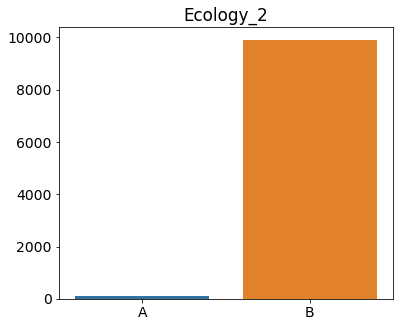

In [82]:
# Замечаем неоднородность данных
plt.figure(figsize=(6,5))    
plt.title('Ecology_2')
sns.barplot(df_train_cat_features['Ecology_2'].value_counts().index, df_train_cat_features['Ecology_2'].value_counts().values)
    
plt.show()

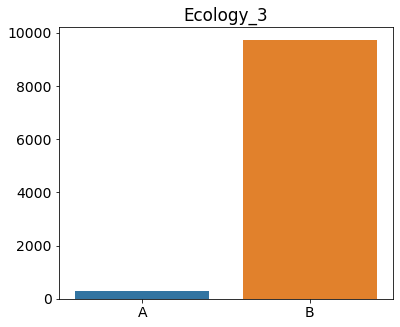

In [83]:
plt.figure(figsize=(6,5))    
plt.title('Ecology_3')
sns.barplot(df_train_cat_features['Ecology_3'].value_counts().index, df_train_cat_features['Ecology_3'].value_counts().values)
    
plt.show()

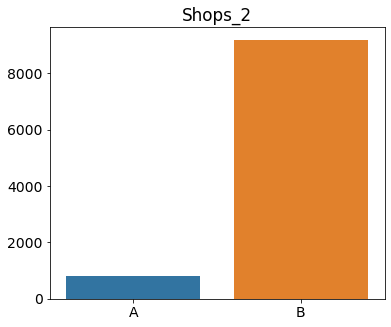

In [84]:
plt.figure(figsize=(6,5))    
plt.title('Shops_2')
sns.barplot(df_train_cat_features['Shops_2'].value_counts().index, df_train_cat_features['Shops_2'].value_counts().values)
    
plt.show()

###### для test

In [85]:
df_test_cat_features.describe()

,Ecology_2,Ecology_3,Shops_2
count,5000,5000,5000
unique,2,2,2
top,B,B,B
freq,4952,4851,4588


### 6.3. Обработка пропусков

###### для train

In [86]:
# Замечаем пропуски в 'LifeSquare', Healthcare_1'
len(df_train_num_features) - df_train_num_features.count()

Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
dtype: int64

In [87]:
df_train_num_features[['Square', 'LifeSquare', 'KitchenSquare']].head()

,Square,LifeSquare,KitchenSquare
0,47.981560,29.442751,6.0
1,65.683640,40.049541,8.0
2,44.947952,29.197611,3.0
3,61.731510,52.731510,9.0
4,39.649193,23.776169,7.0


In [88]:
df_train_num_features['LifeSquare'].median()

32.7812614440918

In [89]:
square_med_diff = (df_train_num_features.loc[df_train_num_features['LifeSquare'].notnull(), 'Square'] -\
                   df_train_num_features.loc[df_train_num_features['LifeSquare'].notnull(), 'LifeSquare'] -\
                   df_train_num_features.loc[df_train_num_features['LifeSquare'].notnull(), 'KitchenSquare']).median()

square_med_diff

11.361442565917969

In [90]:
df_train_num_features.loc[df_train_num_features['LifeSquare'].isnull(), 'LifeSquare'] =\
df_train_num_features.loc[df_train_num_features['LifeSquare'].isnull(), 'Square'] -\
df_train_num_features.loc[df_train_num_features['LifeSquare'].isnull(), 'KitchenSquare'] -\
square_med_diff

In [91]:
# Заполняем пропущенные значения признака 'Healthcare_1' медианой данных этого признака
df_train_num_features.loc[df_train_num_features['Healthcare_1'].isnull(), 'Healthcare_1'] = df_train_num_features['Healthcare_1'].median()

In [92]:
df_train_num_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Rooms          10000 non-null  float32
 1   Square         10000 non-null  float32
 2   LifeSquare     10000 non-null  float32
 3   KitchenSquare  10000 non-null  float32
 4   Floor          10000 non-null  int64  
 5   HouseFloor     10000 non-null  float32
 6   HouseYear      10000 non-null  int32  
 7   Ecology_1      10000 non-null  float32
 8   Social_1       10000 non-null  int8   
 9   Social_2       10000 non-null  int16  
 10  Social_3       10000 non-null  int16  
 11  Healthcare_1   10000 non-null  float32
 12  Helthcare_2    10000 non-null  int8   
 13  Shops_1        10000 non-null  int8   
dtypes: float32(7), int16(2), int32(1), int64(1), int8(3)
memory usage: 459.1 KB


In [93]:
# В категориальных признаках пропусков нет
df_train_cat_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Ecology_2  10000 non-null  category
 1   Ecology_3  10000 non-null  category
 2   Shops_2    10000 non-null  category
dtypes: category(3)
memory usage: 29.7 KB


###### для test

In [94]:
# Замечаем пропуски в 'LifeSquare', Healthcare_1'
len(df_test_num_features) - df_test_num_features.count()

Rooms               0
Square              0
LifeSquare       1041
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2377
Helthcare_2         0
Shops_1             0
dtype: int64

In [95]:
square_med_diff = (df_test_num_features.loc[df_test_num_features['LifeSquare'].notnull(), 'Square'] -\
                   df_test_num_features.loc[df_test_num_features['LifeSquare'].notnull(), 'LifeSquare'] -\
                   df_test_num_features.loc[df_test_num_features['LifeSquare'].notnull(), 'KitchenSquare']).median()

square_med_diff

11.379791259765625

In [96]:
df_test_num_features.loc[df_test_num_features['LifeSquare'].isnull(), 'LifeSquare'] =\
df_test_num_features.loc[df_test_num_features['LifeSquare'].isnull(), 'Square'] -\
df_test_num_features.loc[df_test_num_features['LifeSquare'].isnull(), 'KitchenSquare'] -\
square_med_diff

In [97]:
# Заполняем пропущенные значения признака 'Healthcare_1' медианой данных этого признака
df_test_num_features.loc[df_test_num_features['Healthcare_1'].isnull(), 'Healthcare_1'] = df_test_num_features['Healthcare_1'].median()

In [98]:
df_test_num_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Rooms          5000 non-null   float32
 1   Square         5000 non-null   float32
 2   LifeSquare     5000 non-null   float32
 3   KitchenSquare  5000 non-null   float32
 4   Floor          5000 non-null   int64  
 5   HouseFloor     5000 non-null   float32
 6   HouseYear      5000 non-null   int16  
 7   Ecology_1      5000 non-null   float32
 8   Social_1       5000 non-null   int8   
 9   Social_2       5000 non-null   int16  
 10  Social_3       5000 non-null   int16  
 11  Healthcare_1   5000 non-null   float32
 12  Helthcare_2    5000 non-null   int8   
 13  Shops_1        5000 non-null   int8   
dtypes: float32(7), int16(3), int64(1), int8(3)
memory usage: 219.9 KB


In [99]:
# В категориальных признаках пропусков нет
df_test_cat_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Ecology_2  5000 non-null   category
 1   Ecology_3  5000 non-null   category
 2   Shops_2    5000 non-null   category
dtypes: category(3)
memory usage: 15.1 KB


## 7. Построение новых признаков

### 7.1. Построение новых признаков на основе группировки

###### для train

In [100]:
gp = df_train_num_features.groupby(["Rooms"])["Square"].mean()
df_train_num_features["Mean_Square_by_rooms"] = df_train_num_features["Rooms"].map(gp.to_dict())

df_train_num_features["diff_square_and_mean_square_by_rooms"] = df_train_num_features["Square"] - df_train_num_features["Mean_Square_by_rooms"]

df_train_num_features["ratio_square_and_mean_square_by_rooms"] = df_train_num_features["Square"] / df_train_num_features["Mean_Square_by_rooms"] - 1

df_train_num_features["bigger_then_mean"] = np.where(
    df_train_num_features["diff_square_and_mean_square_by_rooms"] > 0, 1, 0)

df_train_num_features.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Mean_Square_by_rooms,diff_square_and_mean_square_by_rooms,ratio_square_and_mean_square_by_rooms,bigger_then_mean
0,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,33,7976,5,900.0,0,11,57.392654,-9.411095,-0.163977,0
1,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,46,10309,1,240.0,1,16,81.156731,-15.473091,-0.190657,0
2,2.0,44.947952,29.197611,3.0,8,12.0,1968,0.049637,34,7759,0,229.0,1,3,57.392654,-12.444702,-0.216834,0
3,2.0,61.731510,52.731510,9.0,8,17.0,1977,0.437885,23,5735,3,1084.0,0,5,57.392654,4.338856,0.075599,1
4,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,35,5776,1,2078.0,2,4,43.211636,-3.562443,-0.082442,0


###### для test

In [101]:
gp = df_test_num_features.groupby(["Rooms"])["Square"].mean()
df_test_num_features["Mean_Square_by_rooms"] = df_test_num_features["Rooms"].map(gp.to_dict())

df_test_num_features["diff_square_and_mean_square_by_rooms"] = df_test_num_features["Square"] - df_test_num_features["Mean_Square_by_rooms"]

df_test_num_features["ratio_square_and_mean_square_by_rooms"] = df_test_num_features["Square"] / df_test_num_features["Mean_Square_by_rooms"] - 1

df_test_num_features["bigger_then_mean"] = np.where(
    df_test_num_features["diff_square_and_mean_square_by_rooms"] > 0, 1, 0)

df_test_num_features.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Mean_Square_by_rooms,diff_square_and_mean_square_by_rooms,ratio_square_and_mean_square_by_rooms,bigger_then_mean
0,2.0,49.882645,33.432781,6.0,6,14.0,1972,0.310199,11,2748,1,900.0,0,0,57.788033,-7.905388,-0.136800,0
1,2.0,69.263184,54.883392,3.0,1,1.0,1977,0.075779,6,1437,3,900.0,0,2,57.788033,11.475151,0.198573,1
2,1.0,27.948246,15.948246,12.0,2,5.0,1909,0.000000,30,7538,87,4702.0,5,5,41.642578,-13.694332,-0.328854,0
3,2.0,73.046608,51.940842,9.0,22,22.0,2007,0.101872,23,4583,3,900.0,3,3,57.788033,15.258575,0.264044,1
4,1.0,47.527111,43.387569,3.0,17,17.0,2017,0.072158,2,629,1,900.0,0,0,41.642578,5.884533,0.141310,1


### 7.2. Построение новых dummies признаков

###### для train

In [102]:
df_train_cat_features['Ecology_2_bin'] = df_train_cat_features['Ecology_2'].replace({'A':0, 'B':1})
df_train_cat_features['Ecology_3_bin'] = df_train_cat_features['Ecology_3'].replace({'A':0, 'B':1})
df_train_cat_features['Shops_2_bin'] = df_train_cat_features['Shops_2'].replace({'A':0, 'B':1})
df_train_cat_features.head()

,Ecology_2,Ecology_3,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
0,B,B,B,1,1,1
1,B,B,B,1,1,1
2,B,B,B,1,1,1
3,B,B,B,1,1,1
4,B,B,B,1,1,1


###### для test

In [103]:
df_test_cat_features['Ecology_2_bin'] = df_test_cat_features['Ecology_2'].replace({'A':0, 'B':1})
df_test_cat_features['Ecology_3_bin'] = df_test_cat_features['Ecology_3'].replace({'A':0, 'B':1})
df_test_cat_features['Shops_2_bin'] = df_test_cat_features['Shops_2'].replace({'A':0, 'B':1})
df_test_cat_features.head()

,Ecology_2,Ecology_3,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
0,B,B,B,1,1,1
1,B,B,B,1,1,1
2,B,B,B,1,1,1
3,B,B,B,1,1,1
4,B,B,A,1,1,0


### 7.3. Построение новых признаков c помощью статистики

###### для train

In [104]:
district_size = df_train['DistrictId'].value_counts().reset_index()\
               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [105]:
df_train = df_train.merge(district_size, on='DistrictId', how='left')

In [106]:
df_train['IsDistrictLarge'] = (df_train['DistrictSize'] > 100).astype(int)

In [107]:
df_train_stat_features = df_train[['DistrictSize','IsDistrictLarge']]
df_train_stat_features.head()

,DistrictSize,IsDistrictLarge
0,22,0
1,87,0
2,174,1
3,179,1
4,97,0


###### для test

In [108]:
district_size = df_test['DistrictId'].value_counts().reset_index()\
               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,391
1,1,344
2,23,264
3,6,257
4,9,132


In [109]:
df_test = df_test.merge(district_size, on='DistrictId', how='left')

In [110]:
df_test['IsDistrictLarge'] = (df_test['DistrictSize'] > 100).astype(int)

In [111]:
df_test_stat_features = df_test[['DistrictSize','IsDistrictLarge']]
df_test_stat_features.head()

,DistrictSize,IsDistrictLarge
0,91,0
1,61,0
2,2,0
3,49,0
4,391,1


## 8. Отбор признаков

###### для train

In [112]:
df_train_num_features.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Mean_Square_by_rooms,diff_square_and_mean_square_by_rooms,ratio_square_and_mean_square_by_rooms,bigger_then_mean
0,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,33,7976,5,900.0,0,11,57.392654,-9.411095,-0.163977,0
1,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,46,10309,1,240.0,1,16,81.156731,-15.473091,-0.190657,0
2,2.0,44.947952,29.197611,3.0,8,12.0,1968,0.049637,34,7759,0,229.0,1,3,57.392654,-12.444702,-0.216834,0
3,2.0,61.731510,52.731510,9.0,8,17.0,1977,0.437885,23,5735,3,1084.0,0,5,57.392654,4.338856,0.075599,1
4,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,35,5776,1,2078.0,2,4,43.211636,-3.562443,-0.082442,0


In [113]:
df_train_cat_features.head()

,Ecology_2,Ecology_3,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
0,B,B,B,1,1,1
1,B,B,B,1,1,1
2,B,B,B,1,1,1
3,B,B,B,1,1,1
4,B,B,B,1,1,1


In [114]:
df_train_stat_features.head()

,DistrictSize,IsDistrictLarge
0,22,0
1,87,0
2,174,1
3,179,1
4,97,0


In [115]:
# Собираем все признаки
Train = pd.concat([df_train_num_features, df_train_cat_features,df_train_stat_features],axis=1)
Train.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,...,ratio_square_and_mean_square_by_rooms,bigger_then_mean,Ecology_2,Ecology_3,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge
0,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,33,7976,...,-0.163977,0,B,B,B,1,1,1,22,0
1,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,46,10309,...,-0.190657,0,B,B,B,1,1,1,87,0
2,2.0,44.947952,29.197611,3.0,8,12.0,1968,0.049637,34,7759,...,-0.216834,0,B,B,B,1,1,1,174,1
3,2.0,61.731510,52.731510,9.0,8,17.0,1977,0.437885,23,5735,...,0.075599,1,B,B,B,1,1,1,179,1
4,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,35,5776,...,-0.082442,0,B,B,B,1,1,1,97,0


In [116]:
Train.columns.tolist()

['Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Mean_Square_by_rooms',
 'diff_square_and_mean_square_by_rooms',
 'ratio_square_and_mean_square_by_rooms',
 'bigger_then_mean',
 'Ecology_2',
 'Ecology_3',
 'Shops_2',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'Shops_2_bin',
 'DistrictSize',
 'IsDistrictLarge']

In [117]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2_bin', 'Mean_Square_by_rooms',
                 'diff_square_and_mean_square_by_rooms','ratio_square_and_mean_square_by_rooms','bigger_then_mean']
target_name = 'Price'

In [118]:
Train.shape

(10000, 26)

###### для test

In [119]:
# Собираем все признаки
Test = pd.concat([df_test_num_features, df_test_cat_features, df_test_stat_features],axis=1)
Test.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,...,ratio_square_and_mean_square_by_rooms,bigger_then_mean,Ecology_2,Ecology_3,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge
0,2.0,49.882645,33.432781,6.0,6,14.0,1972,0.310199,11,2748,...,-0.136800,0,B,B,B,1,1,1,91,0
1,2.0,69.263184,54.883392,3.0,1,1.0,1977,0.075779,6,1437,...,0.198573,1,B,B,B,1,1,1,61,0
2,1.0,27.948246,15.948246,12.0,2,5.0,1909,0.000000,30,7538,...,-0.328854,0,B,B,B,1,1,1,2,0
3,2.0,73.046608,51.940842,9.0,22,22.0,2007,0.101872,23,4583,...,0.264044,1,B,B,B,1,1,1,49,0
4,1.0,47.527111,43.387569,3.0,17,17.0,2017,0.072158,2,629,...,0.141310,1,B,B,A,1,1,0,391,1


In [120]:
Test = Test[feature_names]

## 9. Построение модели

### 9.1. Разбиение датасета на train/test

In [121]:
X = Train[feature_names]
y = df_train[target_name]

In [122]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, shuffle=True, random_state=21
)

### 9.2. Обучение и оценка модели

#### 9.2.1. Модель RandomForest

In [123]:
# RandomForest
rf_model = RandomForestRegressor(max_depth=20, 
                                 n_estimators=1000, 
                                 min_samples_leaf=30,
                                 max_features = "sqrt",
                                 random_state=21)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=30,
                      n_estimators=1000, random_state=21)

Train R2:	0.685
Test R2:	0.642


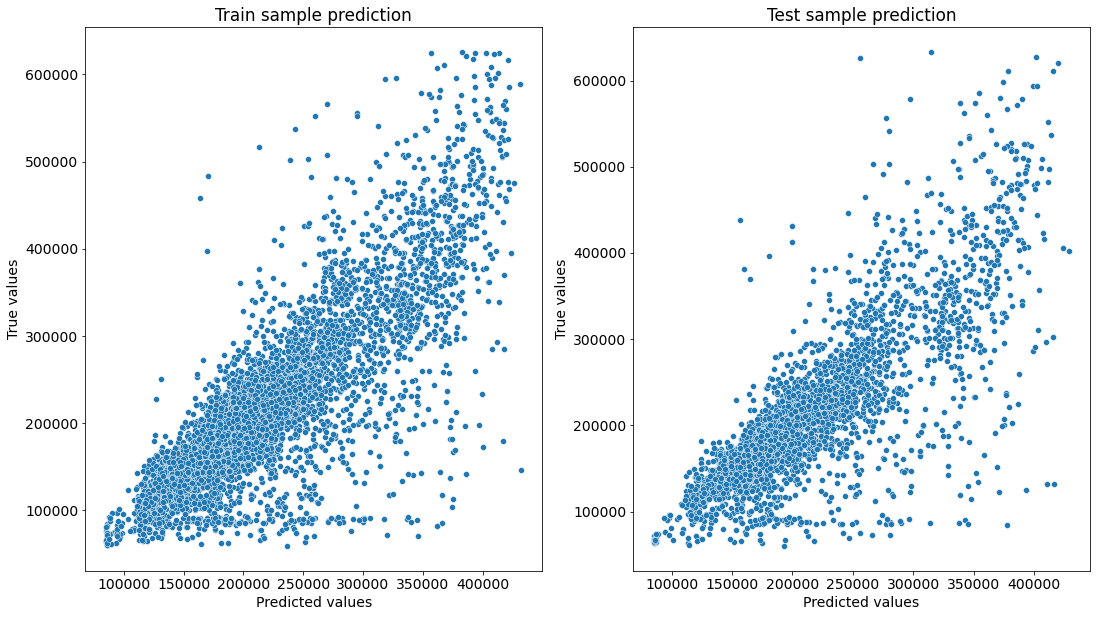

In [124]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

#### Кроссвалидация

In [125]:
cv_score_rf = cross_val_score(
    rf_model,
    X,
    y,
    scoring='r2',
    cv=KFold(n_splits=5, shuffle=True, random_state=1)
)
cv_score_rf

array([0.66236131, 0.65279022, 0.622571  , 0.68685265, 0.66365947])

In [126]:
cv_score_rf.mean() - cv_score_rf.std(), cv_score_rf.mean() + cv_score_rf.std()

(0.6368370383735881, 0.6784568252316349)

**Вывод:** модель стабильная, оценка R2 > 0,6

#### Важность признаков

In [127]:
feature_importances_rf = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances_rf.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.207669
0,Rooms,0.136165
17,Mean_Square_by_rooms,0.120556
11,Social_2,0.087134
2,LifeSquare,0.081454
10,Social_1,0.074028
12,Social_3,0.054242
3,KitchenSquare,0.046312
18,diff_square_and_mean_square_by_rooms,0.038868
19,ratio_square_and_mean_square_by_rooms,0.034671


#### 9.2.2. Модель Gradient Boosting

Train R2:	0.777
Test R2:	0.712


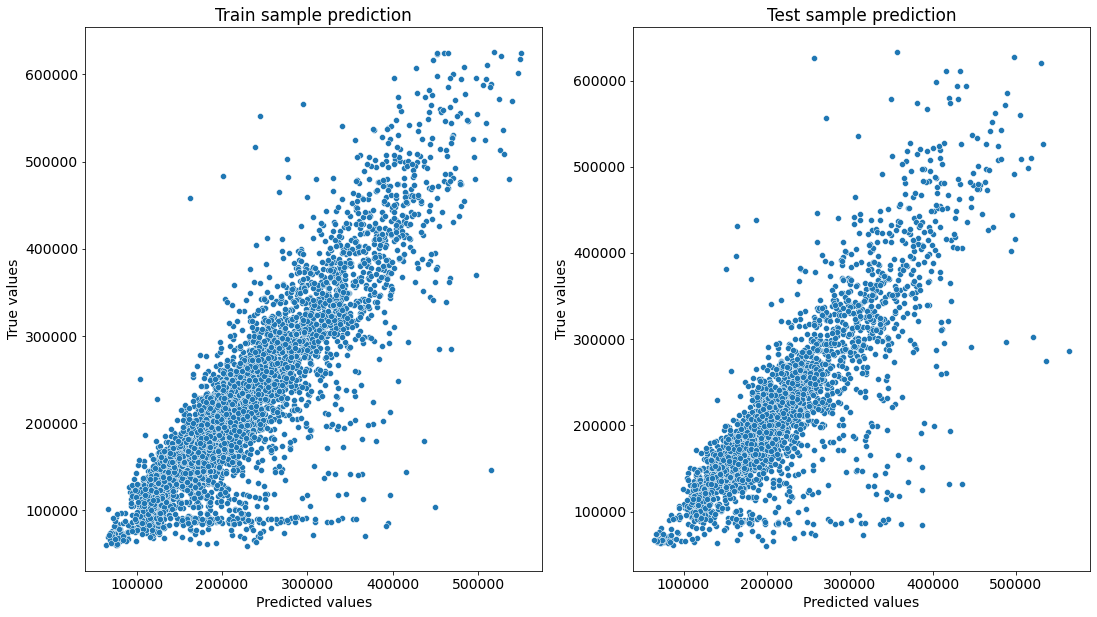

In [128]:
# Gradient Boosting decision trees 
gb_model = GradientBoostingRegressor(max_depth=3,
                                     random_state=21,
                                     min_samples_leaf=30,
                                     max_features = "sqrt",
                                     n_estimators=250)
gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

#### Кроссвалидация

In [129]:
cv_score_gb = cross_val_score(
    gb_model,
    X,
    y,
    scoring='r2',
    cv=KFold(n_splits=5, shuffle=True, random_state=1)
)
cv_score_gb

array([0.72352529, 0.7042255 , 0.70945282, 0.75405995, 0.71568503])

In [130]:
cv_score_gb.mean() - cv_score_gb.std(), cv_score_gb.mean() + cv_score_gb.std()

(0.7038309733267136, 0.7389484667889297)

**Вывод:** модель стабильная, оценка R2 > 0,7

#### Важность признаков

In [131]:
feature_importances_gb = pd.DataFrame(zip(X_train.columns, gb_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances_gb.sort_values(by='importance', ascending=False)

,feature_name,importance
17,Mean_Square_by_rooms,0.182946
1,Square,0.170500
0,Rooms,0.101529
12,Social_3,0.094829
11,Social_2,0.073950
10,Social_1,0.062079
3,KitchenSquare,0.052450
18,diff_square_and_mean_square_by_rooms,0.039236
7,Ecology_1,0.038117
19,ratio_square_and_mean_square_by_rooms,0.033895


## 10. Предсказание на тестовой выборке

In [132]:
# В качестве модели используем Gradient Boosting
final_model = gb_model

In [133]:
# Тестовый набор данных
Test.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2_bin,Ecology_3_bin,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2_bin,Mean_Square_by_rooms,diff_square_and_mean_square_by_rooms,ratio_square_and_mean_square_by_rooms,bigger_then_mean
0,2.0,49.882645,33.432781,6.0,6,14.0,1972,0.310199,1,1,...,2748,1,900.0,0,0,1,57.788033,-7.905388,-0.136800,0
1,2.0,69.263184,54.883392,3.0,1,1.0,1977,0.075779,1,1,...,1437,3,900.0,0,2,1,57.788033,11.475151,0.198573,1
2,1.0,27.948246,15.948246,12.0,2,5.0,1909,0.000000,1,1,...,7538,87,4702.0,5,5,1,41.642578,-13.694332,-0.328854,0
3,2.0,73.046608,51.940842,9.0,22,22.0,2007,0.101872,1,1,...,4583,3,900.0,3,3,1,57.788033,15.258575,0.264044,1
4,1.0,47.527111,43.387569,3.0,17,17.0,2017,0.072158,1,1,...,629,1,900.0,0,0,0,41.642578,5.884533,0.141310,1


In [134]:
# Делаем прогноз целевой переменной на тестовом наборе признаков Test
test_pred = final_model.predict(Test)
test_pred

array([163788.54263016, 199087.62810301, 268388.50248877, ...,
       338142.52102889, 205062.68304841, 200020.26392836])

mu = 217676.65 and sigma = 78191.40


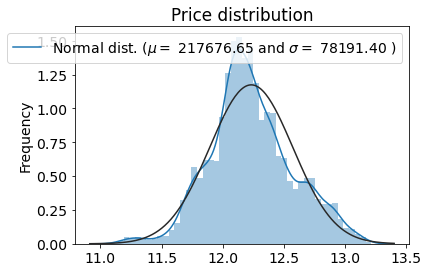

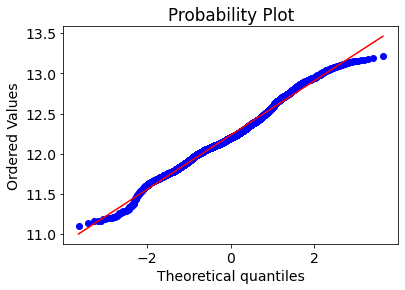

In [135]:
# Оцениваем распределение полученной целевой переменной
Price_log = np.log1p(test_pred)
sns.distplot(Price_log, fit=norm)

mu, sigma = norm.fit(test_pred)

print(f'mu = {mu:.2f} and sigma = {sigma:.2f}')

plt.legend(
    [f'Normal dist. ($\mu=$ {mu:.2f} and $\sigma=$ {sigma:.2f} )'], loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')

# QQ-plot
fig = plt.figure()
res = stats.probplot(Price_log, plot=plt)
plt.show()

## 11. Создание датасета с прогнозами целевой переменной и его сохранение

### 11.1. Создание датасета с готовыми прогнозами целевой переменной

In [136]:
# Представляем значения списком:
# df_test['Id'].tolist()
# test_pred.tolist()
# формируем итоговый датасет
result = pd.DataFrame({
        "Id" : df_test['Id'].tolist(),
        "Price" : test_pred.tolist()
})
result

,Id,Price
0,725,163788.542630
1,15856,199087.628103
2,5480,268388.502489
3,15664,312644.438510
4,14275,134175.066688
...,...,...
4995,8180,236121.810844
4996,4695,118532.165410
4997,5783,338142.521029
4998,4780,205062.683048


### 11.2. Сохранение датасета с готовыми прогнозами целевой переменной

In [137]:
result.to_csv('BazhanovaEN_predictions.csv', index=None)